In [1]:
import os
import tensorflow as tf

from lob.lob_gan import *

%load_ext autoreload
%autoreload 2

imported at 2025-04-19 01:50:07.224731


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
RAW_DATA = pd.read_parquet('lob/BTCUSDT-lob.parq', engine='pyarrow')
assert RAW_DATA.notna().all(axis=None)
RAW_DATA

,E,T,U,u,pu,b0p,b1p,b2p,b3p,b4p,...,a0q,a1q,a2q,a3q,a4q,a5q,a6q,a7q,a8q,a9q
0,1739868923498,1739868923498,6783640382776,6783640393900,6783640382281,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.937,0.190,0.036,0.002,0.095,0.002,0.002,0.002,0.158,0.002
1,1739868923614,1739868923610,6783640396586,6783640404328,6783640393900,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.002,0.095,0.002,0.002,0.002,0.158,0.002,0.002
2,1739868923724,1739868923721,6783640405138,6783640420666,6783640404328,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
3,1739868923827,1739868923821,6783640421340,6783640434389,6783640420666,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
4,1739868923948,1739868923946,6783640436896,6783640445572,6783640434389,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.957,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189755,1739937377488,1739937377486,6791359179849,6791359186272,6791359179542,95733.3,95733.2,95733.1,95733.0,95732.9,...,0.884,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189756,1739937377596,1739937377595,6791359186752,6791359194092,6791359186272,95733.3,95733.2,95733.1,95733.0,95732.9,...,1.438,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189757,1739937377698,1739937377697,6791359194379,6791359202977,6791359194092,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.604,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002
189758,1739937377806,1739937377806,6791359203537,6791359209077,6791359202977,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.453,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002


In [4]:
%%time

SAMPLE_SIZE = min(len(RAW_DATA), Configs().sample_size)
BATCH_SIZE = SAMPLE_SIZE // Configs().n_batches

LOB_DATASET = create_dataset(RAW_DATA, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)

CPU times: user 20.3 ms, sys: 9.09 ms, total: 29.4 ms
Wall time: 28.2 ms


{'neg_qty_sum': 0.0,
 'neg_qty_count': 0.0,
 'neg_diff_sum': 0.0,
 'neg_diff_count': 0.0}

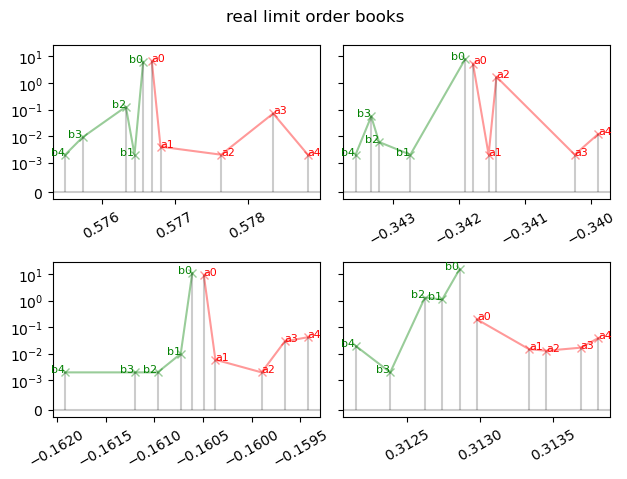

CPU times: user 1.11 s, sys: 92.6 ms, total: 1.2 s
Wall time: 541 ms


In [5]:
%%time

for i, batch in enumerate(LOB_DATASET):
    ss = calculate_sample_stats(batch)
    display(ss)
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True)
    f.suptitle('real limit order books')
    plot_lob_snapshot(batch[0], ax0)
    plot_lob_snapshot(batch[1], ax1)
    plot_lob_snapshot(batch[2], ax2)
    plot_lob_snapshot(batch[3], ax3)
    plt.tight_layout()
    plt.show()
    break

In [6]:
# gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.0))
# outputs = gan.train()
# plot_training_history(outputs.metrics)
# plot_lobs(outputs.lobs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:14<00:00,  1.17s/it]

Training completed in 1.26 minutes
plot_training_history


,disc_loss,real_loss,fake_loss,gen_loss,adv_loss,fm_loss,real_prob,fake_prob,neg_qty_sum,neg_qty_count,neg_diff_sum,neg_diff_count
0,1.800614,1.040285,0.760328,43121.503906,0.669630,43120.834473,0.464080,0.521708,0.815773,3.1248,9.881533,17.989599
1,1.151033,0.490786,0.660247,40897.129639,0.776525,40896.353516,0.652559,0.472379,0.593092,2.4648,8.533762,16.152800
2,0.827144,0.279143,0.548001,38851.887207,0.929040,38850.958008,0.775992,0.411014,0.424387,1.9416,7.426401,14.530399
3,0.643237,0.210744,0.432493,36962.545166,1.136858,36961.408203,0.826062,0.341007,0.296616,1.4936,6.511515,13.013599
4,0.509534,0.180325,0.329208,35200.300293,1.392701,35198.907715,0.850293,0.271930,0.204493,1.1064,5.758549,11.638400
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.005374,0.005369,0.000005,6582.908630,18.214614,6564.694000,0.994870,0.000005,0.002121,0.0208,0.000126,0.003200
60,0.005223,0.005218,0.000004,6507.761047,18.516301,6489.244690,0.995012,0.000004,0.002132,0.0232,0.000032,0.000800
61,0.005079,0.005075,0.000004,6435.881592,18.816398,6417.065186,0.995147,0.000004,0.002158,0.0232,0.000010,0.000800
62,0.004941,0.004938,0.000003,6367.091797,19.114826,6347.976990,0.995276,0.000003,0.002185,0.0224,0.000000,0.000000


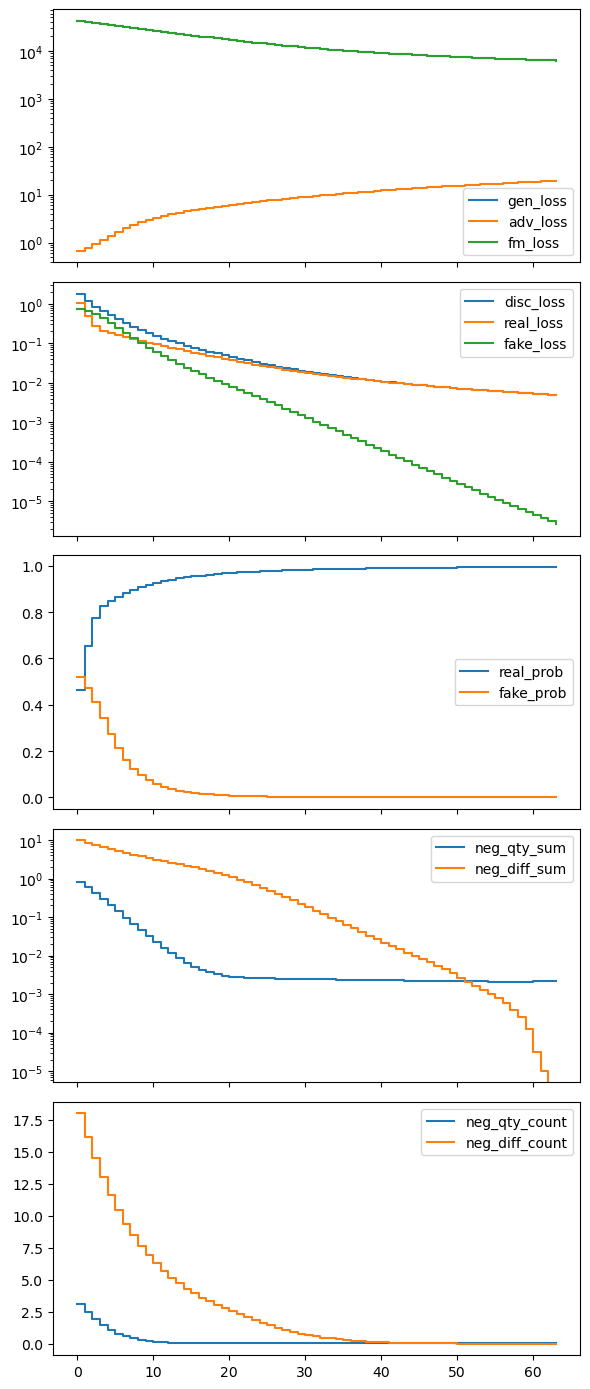

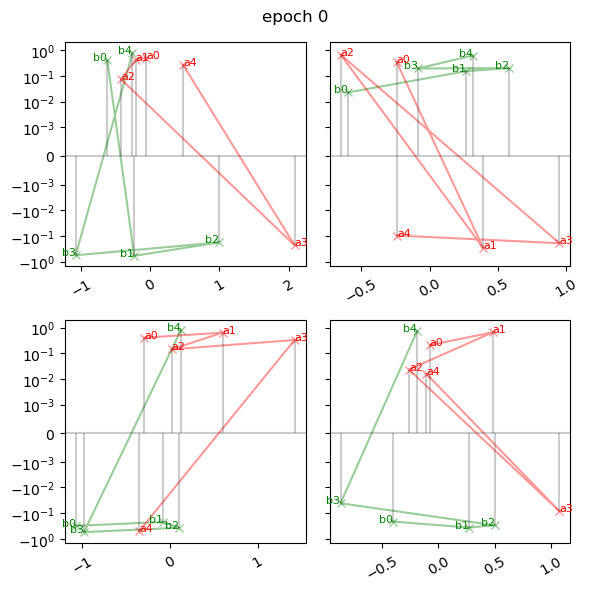

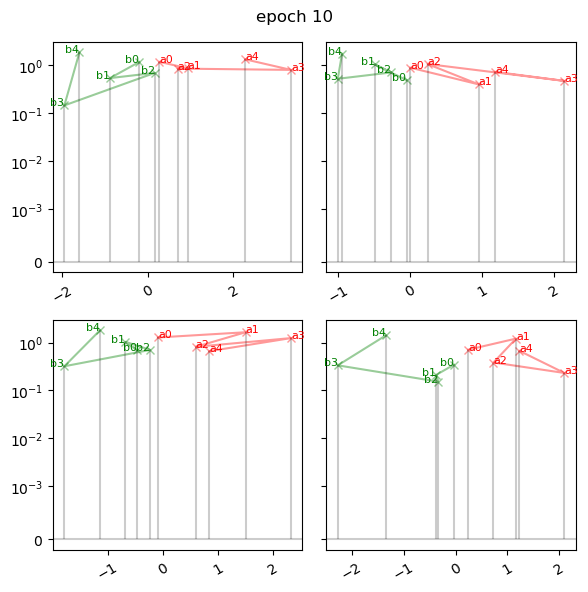

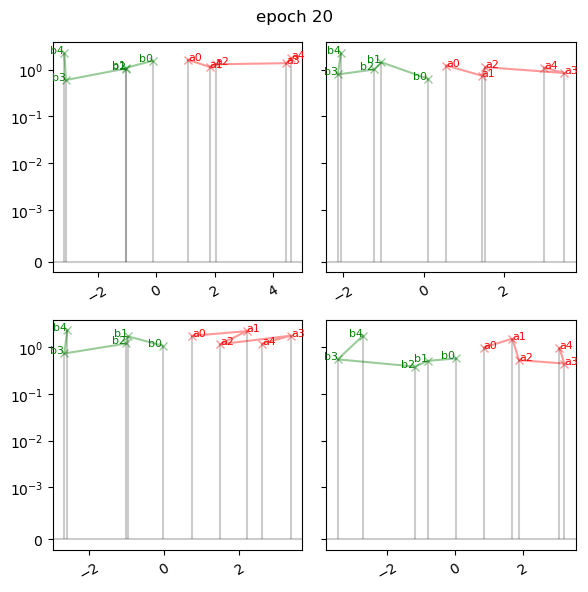

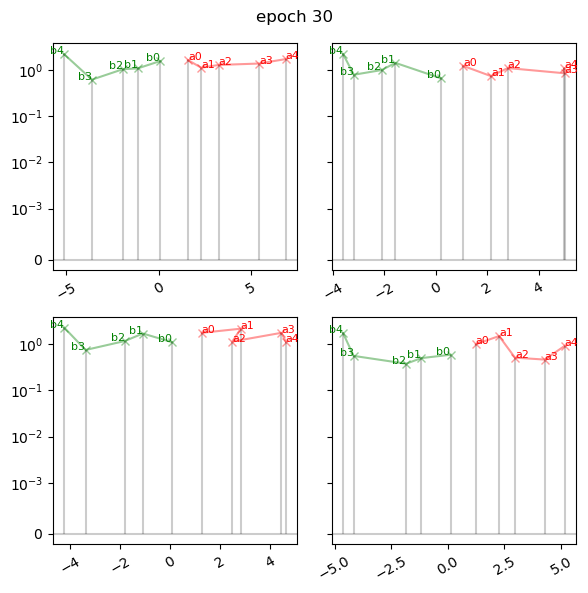

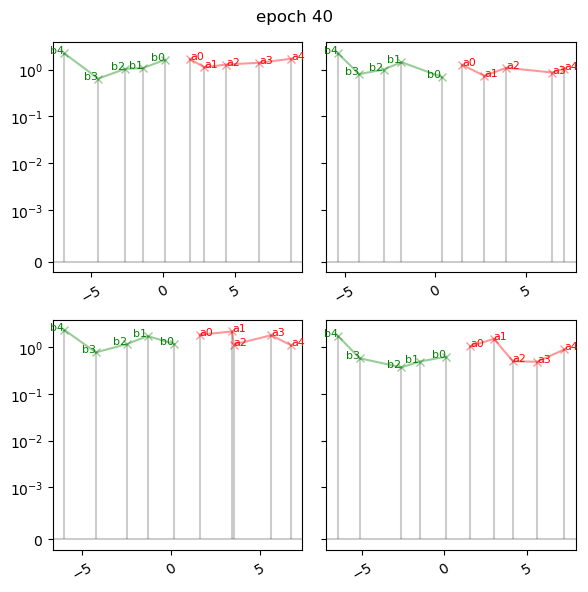

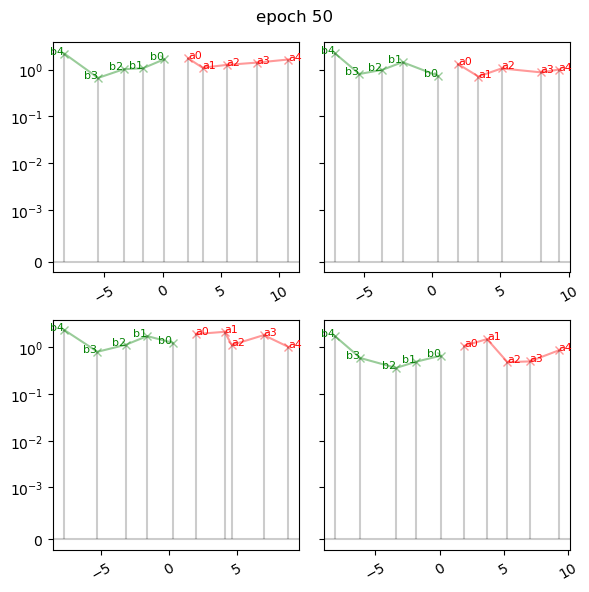

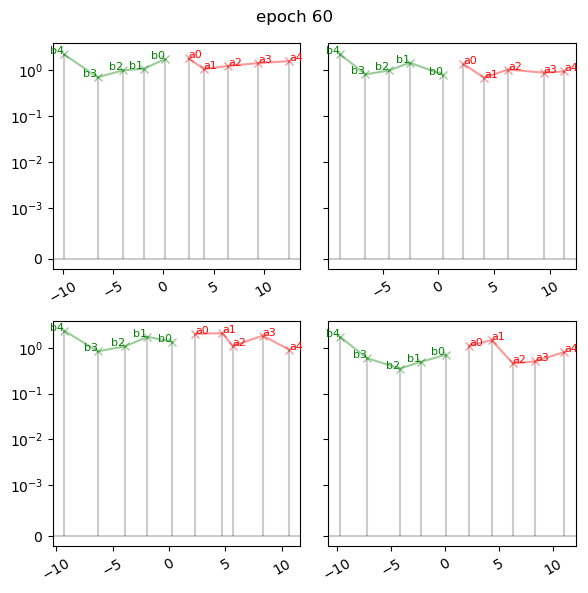

In [7]:
gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.5))
outputs = gan.train()
plot_training_history(outputs.metrics)
plot_lobs(outputs.lobs)